Importamos todos los paquetes necesarios para el proyecto:

In [26]:
from search import *
import matplotlib.pyplot as plt
import os
import numpy as np

Definimos la orientación de cada vector

In [27]:
# Vectores de dirección para las orientaciones
orientation_vectors = {
    0: (0, -1),   # North
    1: (1, -1), # Northeast
    2: (1, 0),    # East
    3: (1, 1),  # Southeast
    4: (0, 1),    # South
    5: (-1, 1), # Southwest
    6: (-1, 0),   # West
    7: (-1, -1) # Northwest
}

In [38]:
# Vectores de dirección para las orientaciones
orientation_vectors = {
    0: (-1, 0),   # North
    1: (-1, 1), # Northeast
    2: (0, 1),    # East
    3: (1, 1),  # Southeast
    4: (1, 0),    # South
    5: (1, -1), # Southwest
    6: (0, -1),   # West
    7: (-1, -1) # Northwest
}

## Lectura de los datos

La función `read_map` permite procesar los distintos elementos presentes en el fichero de definición del problema. 

Recibe:
- *file*: nombre del fichero.
- *origin_dir*: directorio en el que está el fichero. Por defecto toma el de trabajo.

Devuelve:
- *dimension*: dimensiones del mapa.
- *map_data*: matriz con el mapa.
- *start_point*: lista de tamaño 3 con el punto y la orientación iniciales.
- *end_point*: lista de tamaño 2 con el punto final.

In [28]:
def read_map(file, origin_dir = os.getcwd()):
    
    file_path = os.path.join(origin_dir, file)
    
    # Abrir y leer el archivo
    with open(file_path, 'r') as file:
        lines = file.readlines()

    # Leer la dimensión del mapa (primera línea)
    dimension = list(map(int, lines[0].split()))
    rows, cols = dimension  # Número de filas y columnas

    # Leer el mapa según las dimensiones especificadas
    map_data = np.array([list(map(int, lines[i + 1].split())) for i in range(rows)])

    # Leer el punto inicial y su orientación (penúltima línea)
    start_position = tuple(map(int, lines[-2].split()))

    # Leer el punto final y su orientación (última línea)
    end_position = tuple(map(int, lines[-1].split()))[:2]
    
    return dimension, map_data, start_position, end_position

La función `draw_map` permite representar visualmente el mapa del problema. 

Recibe:
- *dimension*: dimensiones del mapa.
- *map_data*: matriz con el mapa.
- *start_point*: lista de tamaño 3 con el punto y la orientación iniciales.
- *end_point*: lista de tamaño 2 con el punto final.

In [29]:
# Mostrar el mapa en una forma visual usando matplotlib
def draw_map(dimension, map_data, start_position, end_position):
    # Convertir el mapa en una matriz numpy
    map_array = np.array(map_data)
    
    rows, cols = dimension[0], dimension[1]
    
    orientation = start_position[2]

    # Dibujar el mapa
    plt.imshow(map_array, cmap="Blues", origin="upper")
    
    # Agregar los valores de cada celda (peso)
    for i in range(rows):
        for j in range(cols):
            plt.text(j, i, str(map_array[i, j]), color='black', fontsize=12, ha='center', va='center')

    # Agregar el punto inicial y final
    if orientation == 7:
        plt.text(start_position[1]+0.3, start_position[0]+0.3, 'S', color='red', fontsize=12, ha='center', va='center', fontweight='bold')
    else:
        plt.text(start_position[1]-0.3, start_position[0]-0.3, 'S', color='red', fontsize=12, ha='center', va='center', fontweight='bold')
    plt.text(end_position[1]-0.3, end_position[0]-0.3, 'E', color='green', fontsize=12, ha='center', va='center', fontweight='bold')
    
    # Agregar la orientación inicial como una flecha
    arrow_dx, arrow_dy = [x/2 for x in orientation_vectors[orientation]]
    plt.arrow(start_position[1]+arrow_dx/2, start_position[0]+arrow_dy/2, arrow_dx, arrow_dy, head_width=0.1, head_length=0.1, fc='red', ec='red')

    # Configuración de la cuadrícula
    plt.grid(True, color="black", linewidth=1)
    plt.xticks(np.arange(cols))
    plt.yticks(np.arange(rows))

    # Quitar la cuadrícula
    plt.axis('off')

    # Mostrar el mapa
    plt.show()

Dibujamos algunos ejemplos:

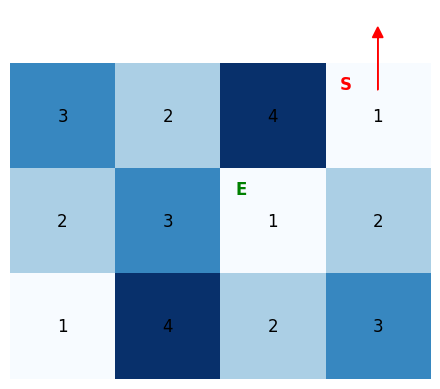

In [37]:
dimension, map_data, start_position, end_position = read_map("exampleMap.txt")
draw_map(dimension, map_data, start_position, end_position)

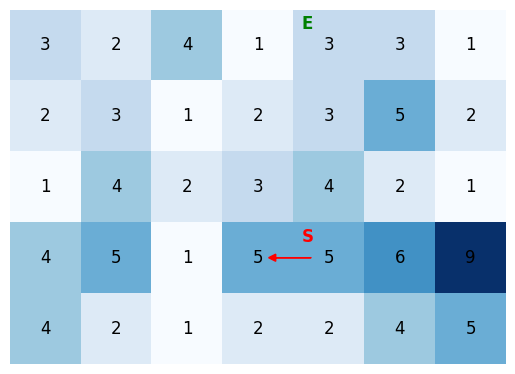

In [31]:
dimension, map_data, start_position, end_position = read_map("exampleMap_2.txt")
draw_map(dimension, map_data, start_position, end_position)

In [32]:
class RobotProblem(Problem):

    def __init__(self, initial, goal, map):
        Problem.__init__(self, initial, goal)
        self.map_data = map_data
        self.dimensions = map_data.shape

    def actions(self, state):
        actions = []
        actions.append((state[0], state[1], (state[2] - 1) % 8))
        actions.append((state[0], state[1], (state[2] + 1) % 8))
        new_position = [state[0] + orientation_vectors[state[2]][0], state[1] + orientation_vectors[state[2]][1]]
        if 0 <= new_position[0] < self.dimensions[0] and 0 <= new_position[1] < self.dimensions[1]:
            actions.append((new_position[0], new_position[1], state[2]))
        return actions
    
    def result(self, state, action):
        return action
    
    def goal_test(self, state):
        return state[:2] == self.goal[:2]
    
    def path_cost(self, cost_so_far, state1, action, state2):
        if state1[:2] == state2[:2]:
            return cost_so_far + 1
        else:
            return cost_so_far + self.map_data[state2[0], state2[1]]

In [39]:
dimension, map_data, start_position, end_position = read_map("exampleMap.txt")
robot_problem = RobotProblem(start_position, end_position, map_data)
robot_problem.map_data

array([[3, 2, 4, 1],
       [2, 3, 1, 2],
       [1, 4, 2, 3]])

In [42]:
node = breadth_first_graph_search(robot_problem)
node.solution()
node.path_cost
#display_visual(romania_graph_data, user_input=False, algorithm=breadth_first_tree_search, problem=robot_problem)

4